In [1]:
from pyib.ml.models import *
import torch
from pyib.ml.train_utils import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pyib.md.utils import TrajectoryReader
from scipy.special import logsumexp
from pyib.ml.utils import bin_FE, projectFEToRC
import matplotlib as mpl
import os
from scipy.stats import binned_statistic_dd

In [2]:
# Constants
DATA_PATH = "data/traj_slip_bond_f_0.dat"
NUM_LABELS = 10

if not os.path.exists("tmp"):
    os.makedirs("tmp")

LABEL_PATH= "tmp/slip_bond_labels_{}.npy".format(NUM_LABELS)

In [3]:
traj = TrajectoryReader(DATA_PATH)
time, data = traj.read_traj()
data = (data[:,:2] - data[:,:2].mean(axis=0))/data[:,:2].std(axis=0)

# Make temporary labels

In [4]:
DIM = 1
minY = data[:,DIM].min() - 1e-3
maxY = data[:,DIM].max() + 1e-3

range_ = np.linspace(minY, maxY,NUM_LABELS+1)
digitized = np.digitize(data[:,DIM],range_)-1
np.save(LABEL_PATH,digitized)
labels = np.load(LABEL_PATH)

meanPos = []
for i in range(NUM_LABELS):
    index = np.argwhere(digitized == i)
    mean = data[index].mean(axis=0)
    meanPos.append(mean[0])

Text(0.5, 1.0, 'Slip bond initial label')

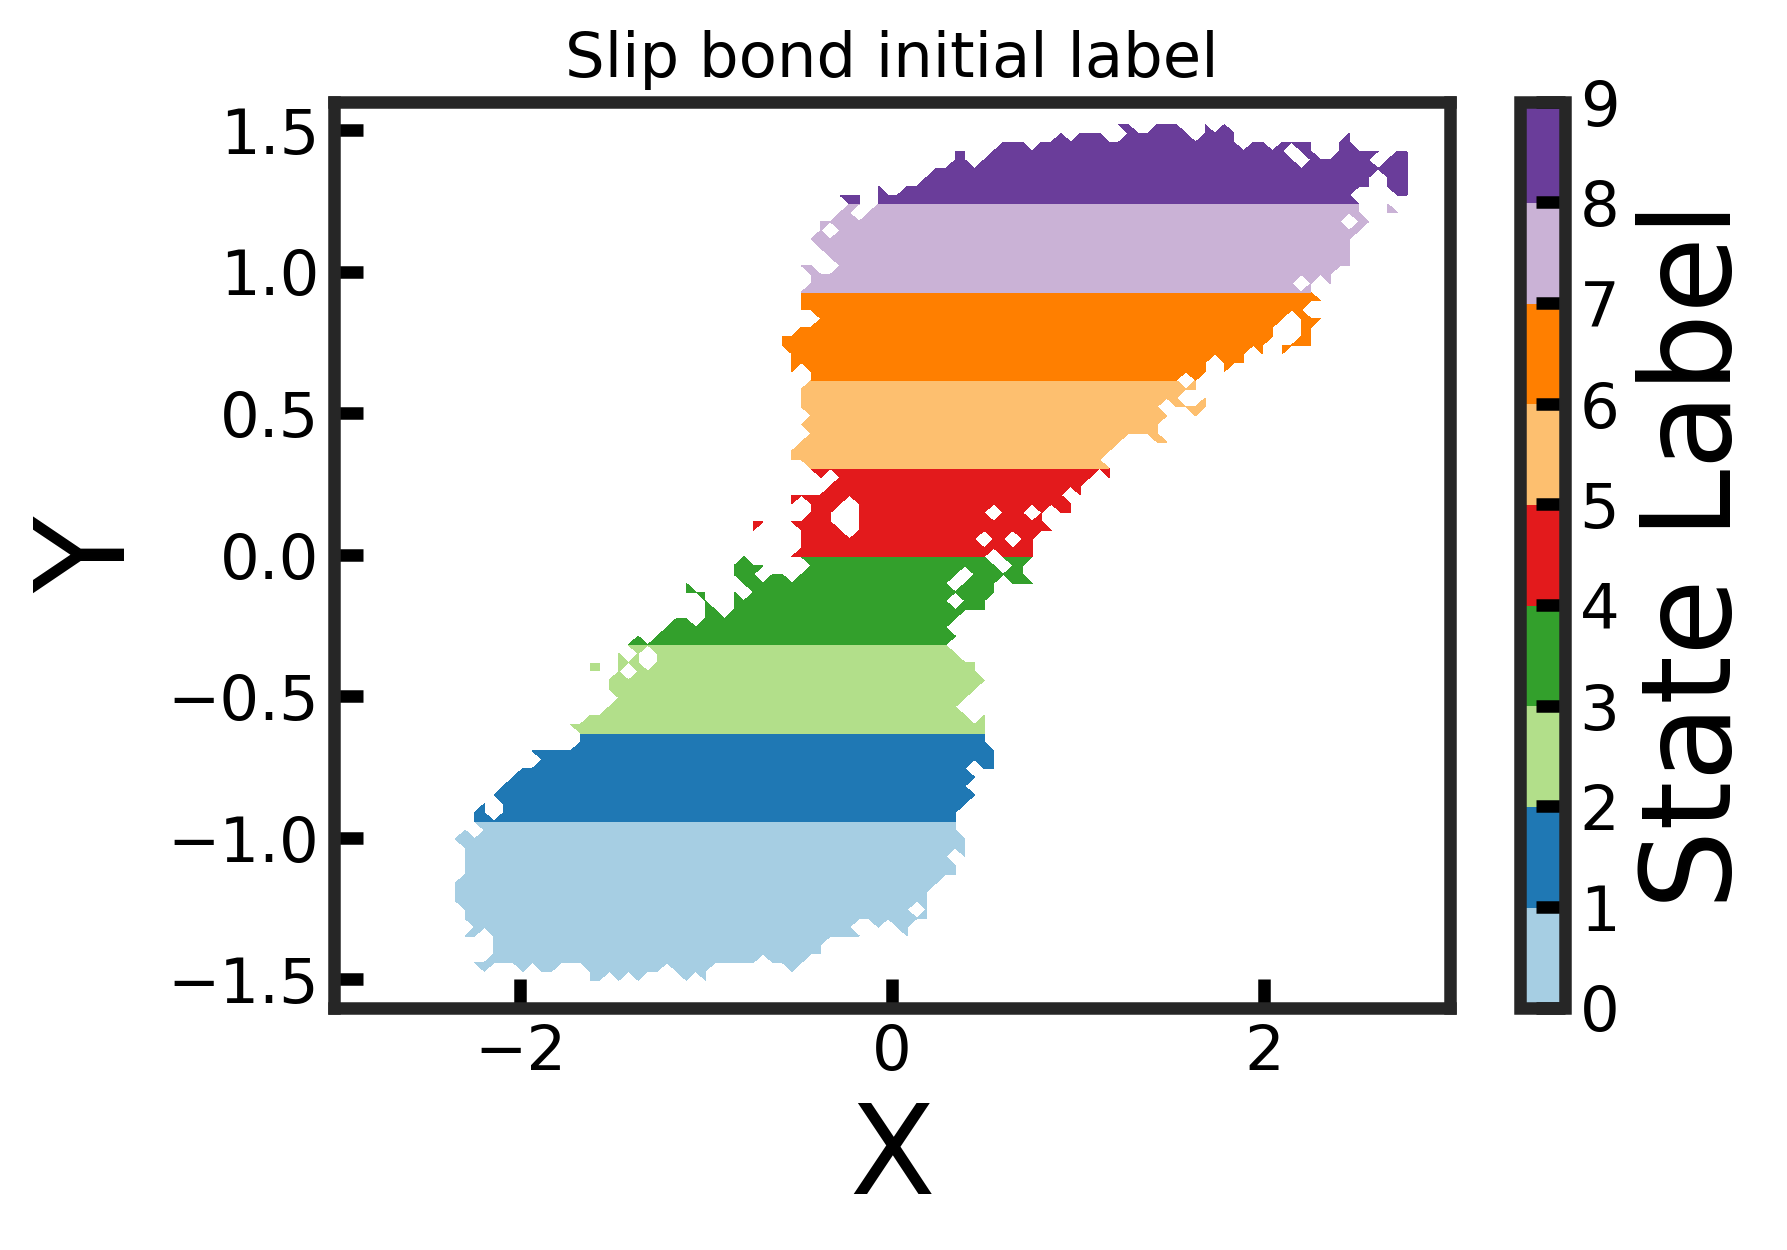

In [5]:
one_hot = np.zeros((labels.shape[0],NUM_LABELS))
vec = np.arange(one_hot.shape[0])
one_hot[vec, labels] = 1

BINS = 100
histogram,x,y = np.histogram2d(data[:,0],data[:,1],bins=BINS)

hist = np.zeros((NUM_LABELS,BINS,BINS))
for i in range(NUM_LABELS):
    hist[i] = np.histogram2d(data[:,0],data[:,1],bins=[x,y],weights=one_hot[:,i])[0]
initialLab = np.argmax(hist, axis=0).astype(float)
initialLab[histogram==0] = np.nan

ax = plt.figure(dpi=300).add_subplot(111)
levels = np.arange(10)
cMap = mpl.colors.ListedColormap(plt.cm.Paired.colors[0:10])
p  = ax.contourf(x[:-1],y[:-1],initialLab.T,cmap=cMap,levels=levels)
cbar = plt.colorbar(p)
ax.set_xlim(-3,3)
ax.set_ylim(-1.6,1.6)
cbar.set_label("State Label")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Slip bond initial label")

# Plot free energy

Text(0, 0.5, 'Y')

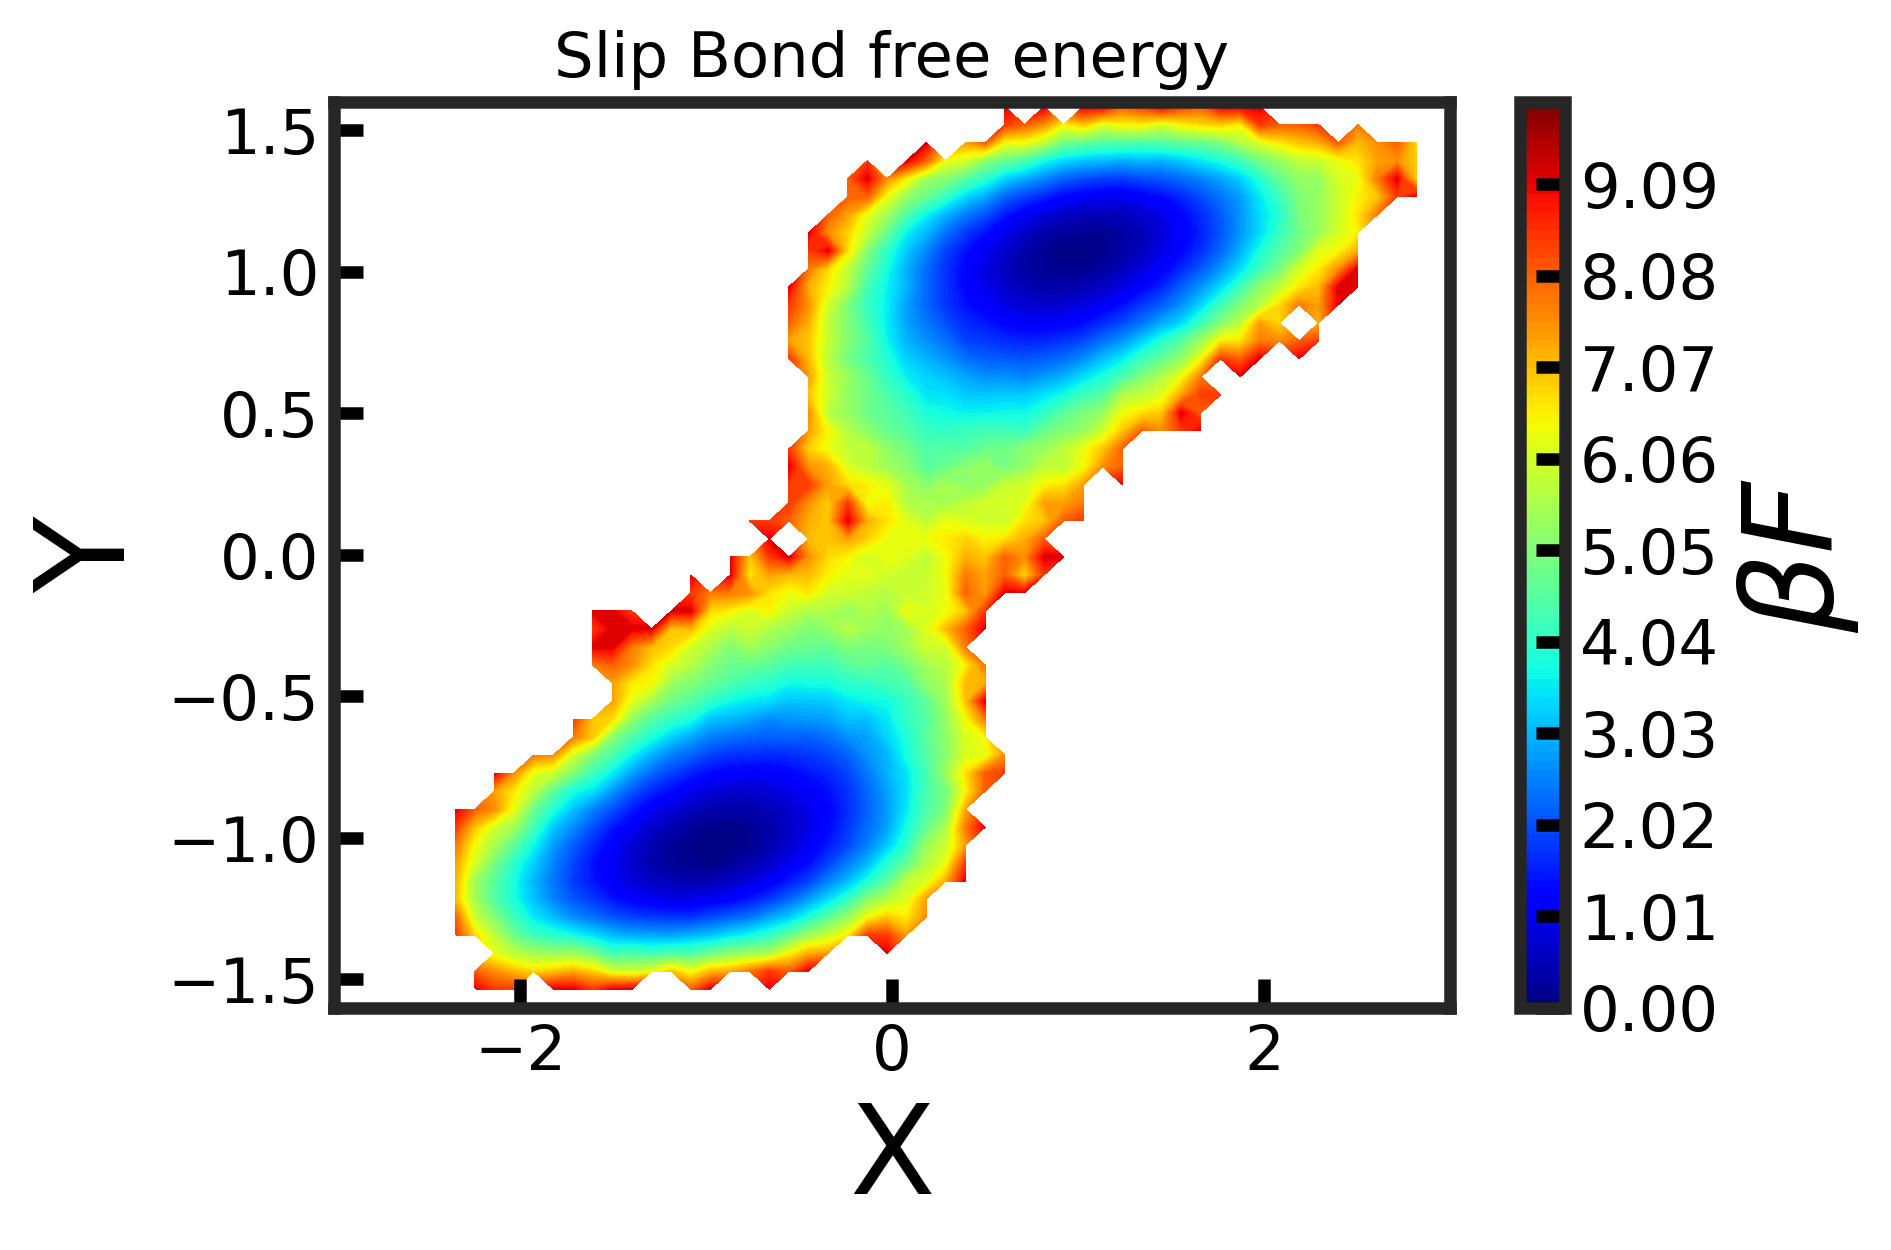

In [6]:
min_ = data.min(axis=0) - 1e-3
max_ = data.max(axis=0) + 1e-3

x = np.linspace(min_[0], max_[0])
y = np.linspace(min_[1], max_[1])

FE, weights = bin_FE(data, 50)

levels = np.linspace(0,10,100)
ax = plt.figure(dpi=300).add_subplot(111)
c = ax.contourf(x,y,FE.T,cmap='jet',levels=levels)
cbar = plt.colorbar(c)
ax.set_xlim(-3,3)
ax.set_ylim(-1.6,1.6)
ax.set_title("Slip Bond free energy")
cbar.set_label(r"$\beta F$")
ax.set_xlabel("X")
ax.set_ylabel("Y")

### Initialize SPIB

In [7]:
# Dimensions
INPUT_DIM  = 2
OUTPUT_DIM = NUM_LABELS
NEURON_DIM = 16
HIDDEN_DIM = 1

# Specify specific SPIB parameters
encoder_dim = [INPUT_DIM, NEURON_DIM, NEURON_DIM]
hidden_dim = HIDDEN_DIM
decoder_dim = [NEURON_DIM, NEURON_DIM, OUTPUT_DIM]
restrictLogVar = False

SEED = 0

# Specify SPIB model
device = "cuda" if torch.cuda.is_available() else "cpu"
v = SPIB(encoder_dim, hidden_dim, decoder_dim, activation=nn.ReLU(),device=device, restrictLogVar=restrictLogVar)

In [8]:
lagTime = 300
torch.manual_seed(SEED)
SPIB_train(v, DATA_PATH, LABEL_PATH, \
            lagTime, epochs=5, print_every=1,beta=0.01, \
            update_labels=True,batch_size=1024, one_hot=False, threshold=0.01,patience=2)

-----------------------------------
At Epoch 1
Average epoch Loss = 1.14199
Average KL loss = 0.73575
Average CE loss = 1.13464
Average test Loss = 0.93283
State population =  tensor([0.0000, 0.5114, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4886,
        0.0000])
State population change = 1.22485
-----------------------------------
At Epoch 2
Average epoch Loss = 0.92961
Average KL loss = 0.67501
Average CE loss = 0.92286
Average test Loss = 0.92993
State population =  tensor([0.0000e+00, 5.1142e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0012e-05, 4.8854e-01, 0.0000e+00])
State population change = 0.00013
-----------------------------------
At Epoch 3
Average epoch Loss = 0.92693
Average KL loss = 0.54334
Average CE loss = 0.92150
Average test Loss = 0.92933
State population =  tensor([0.0000, 0.5115, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4885,
        0.0000])
State population change = 0.00007
-----------------------------------
At 

(-1.6, 1.6)

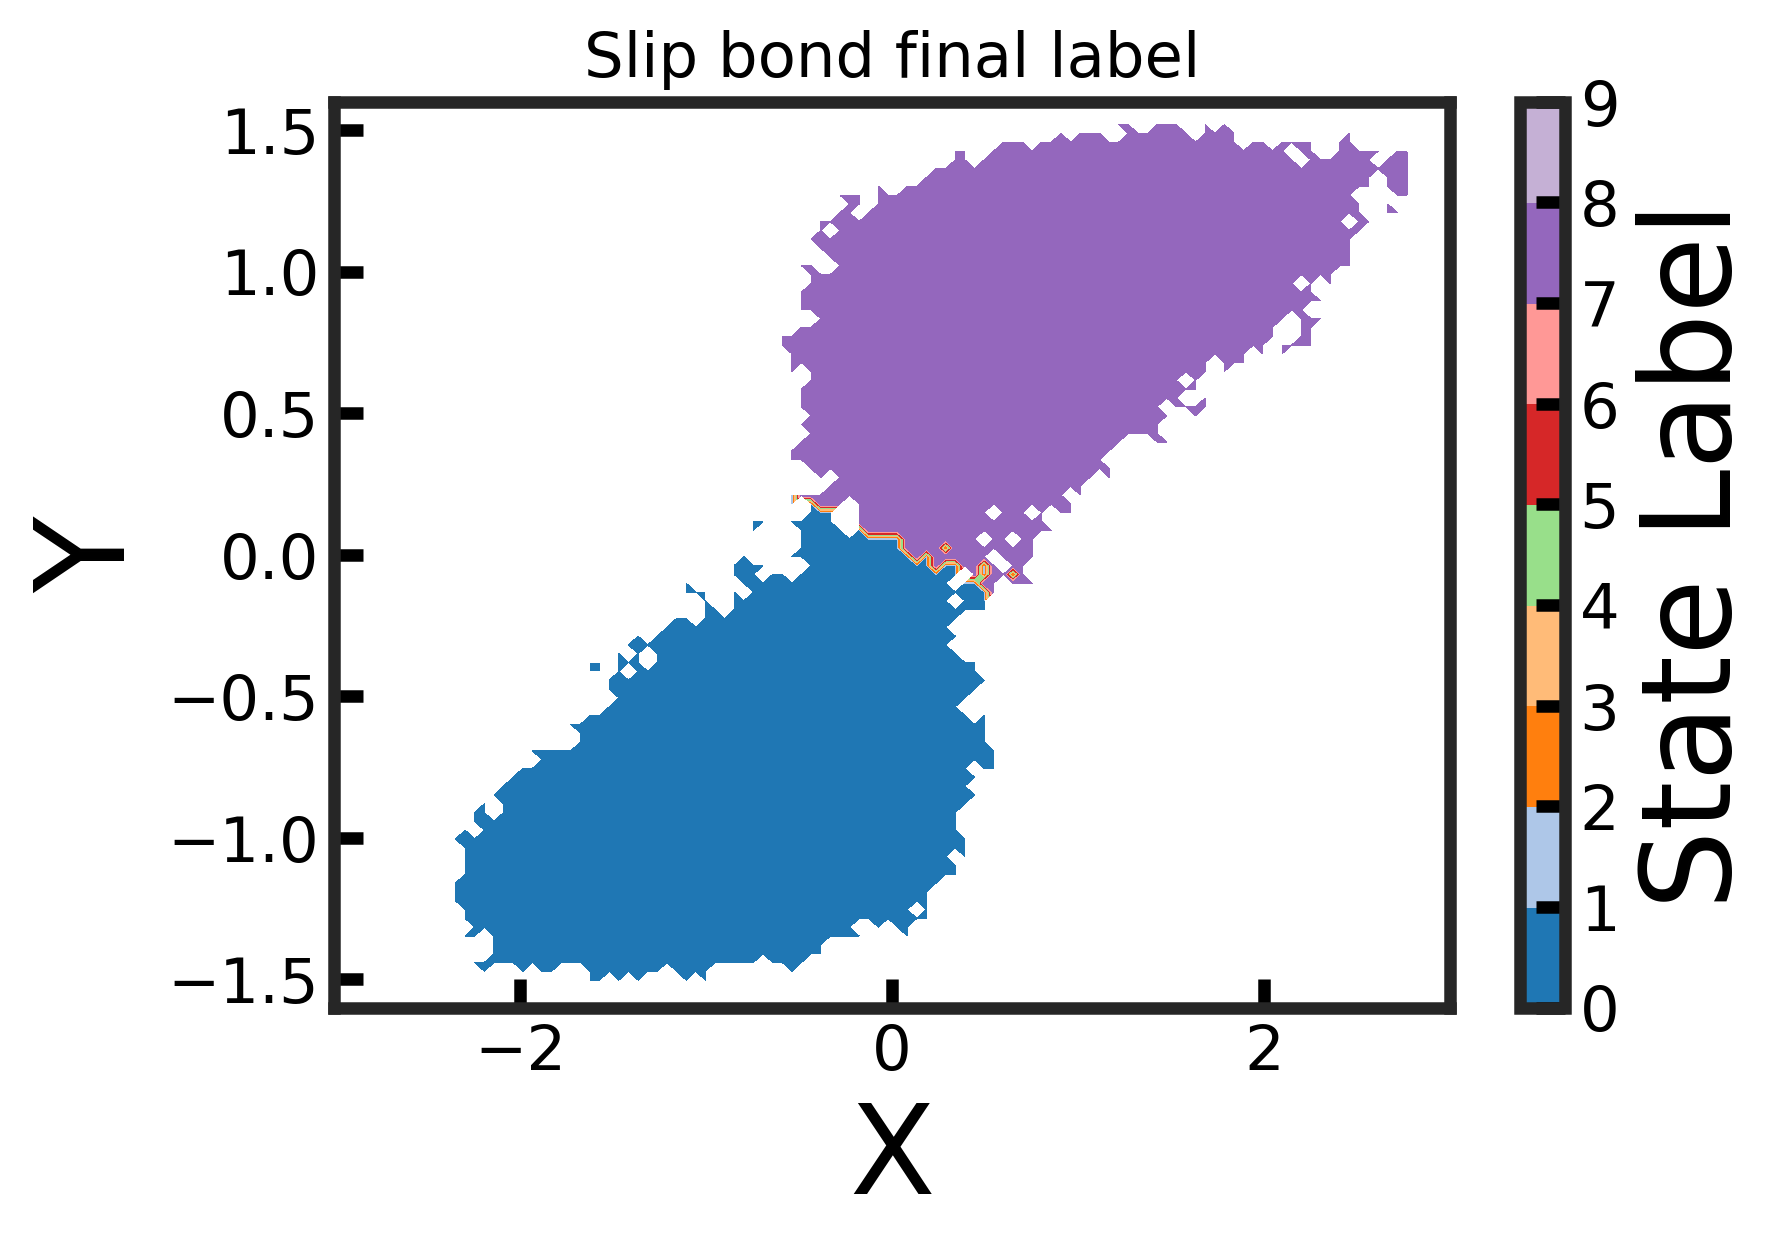

In [9]:
d = torch.tensor(data[:,:2], dtype=torch.float32)
l,mean,_,_ = v.evaluate(d)

one_hot = np.zeros((l.shape[0],NUM_LABELS))
index = np.arange(l.shape[0])
one_hot[index,l.flatten()] = 1

BINS = 100
histogram,x,y = np.histogram2d(data[:,0],data[:,1],bins=BINS)

hist = np.zeros((NUM_LABELS,BINS,BINS))
for i in range(NUM_LABELS):
    hist[i] = np.histogram2d(data[:,0],data[:,1],bins=[x,y],weights=one_hot[:,i])[0]
initialLab = np.argmax(hist, axis=0).astype(float)
initialLab[histogram==0] = np.nan

ax = plt.figure(dpi=300).add_subplot(111)
levels = np.arange(10)
cMap = mpl.colors.ListedColormap(plt.cm.tab20.colors[0:10])
p  = ax.contourf(x[:-1],y[:-1],initialLab.T,cmap=cMap,levels=levels)
cbar = plt.colorbar(p)
cbar.set_label("State Label")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Slip bond final label")
ax.set_xlim(-3,3)
ax.set_ylim(-1.6,1.6)

<ipython-input-10-b8959f1e5f67>:3: RuntimeWarning: invalid value encountered in true_divide
  histRC = histMean/histdata


Text(0.5, 1.0, 'Slip bond $\\Delta$ t = 250 ps')

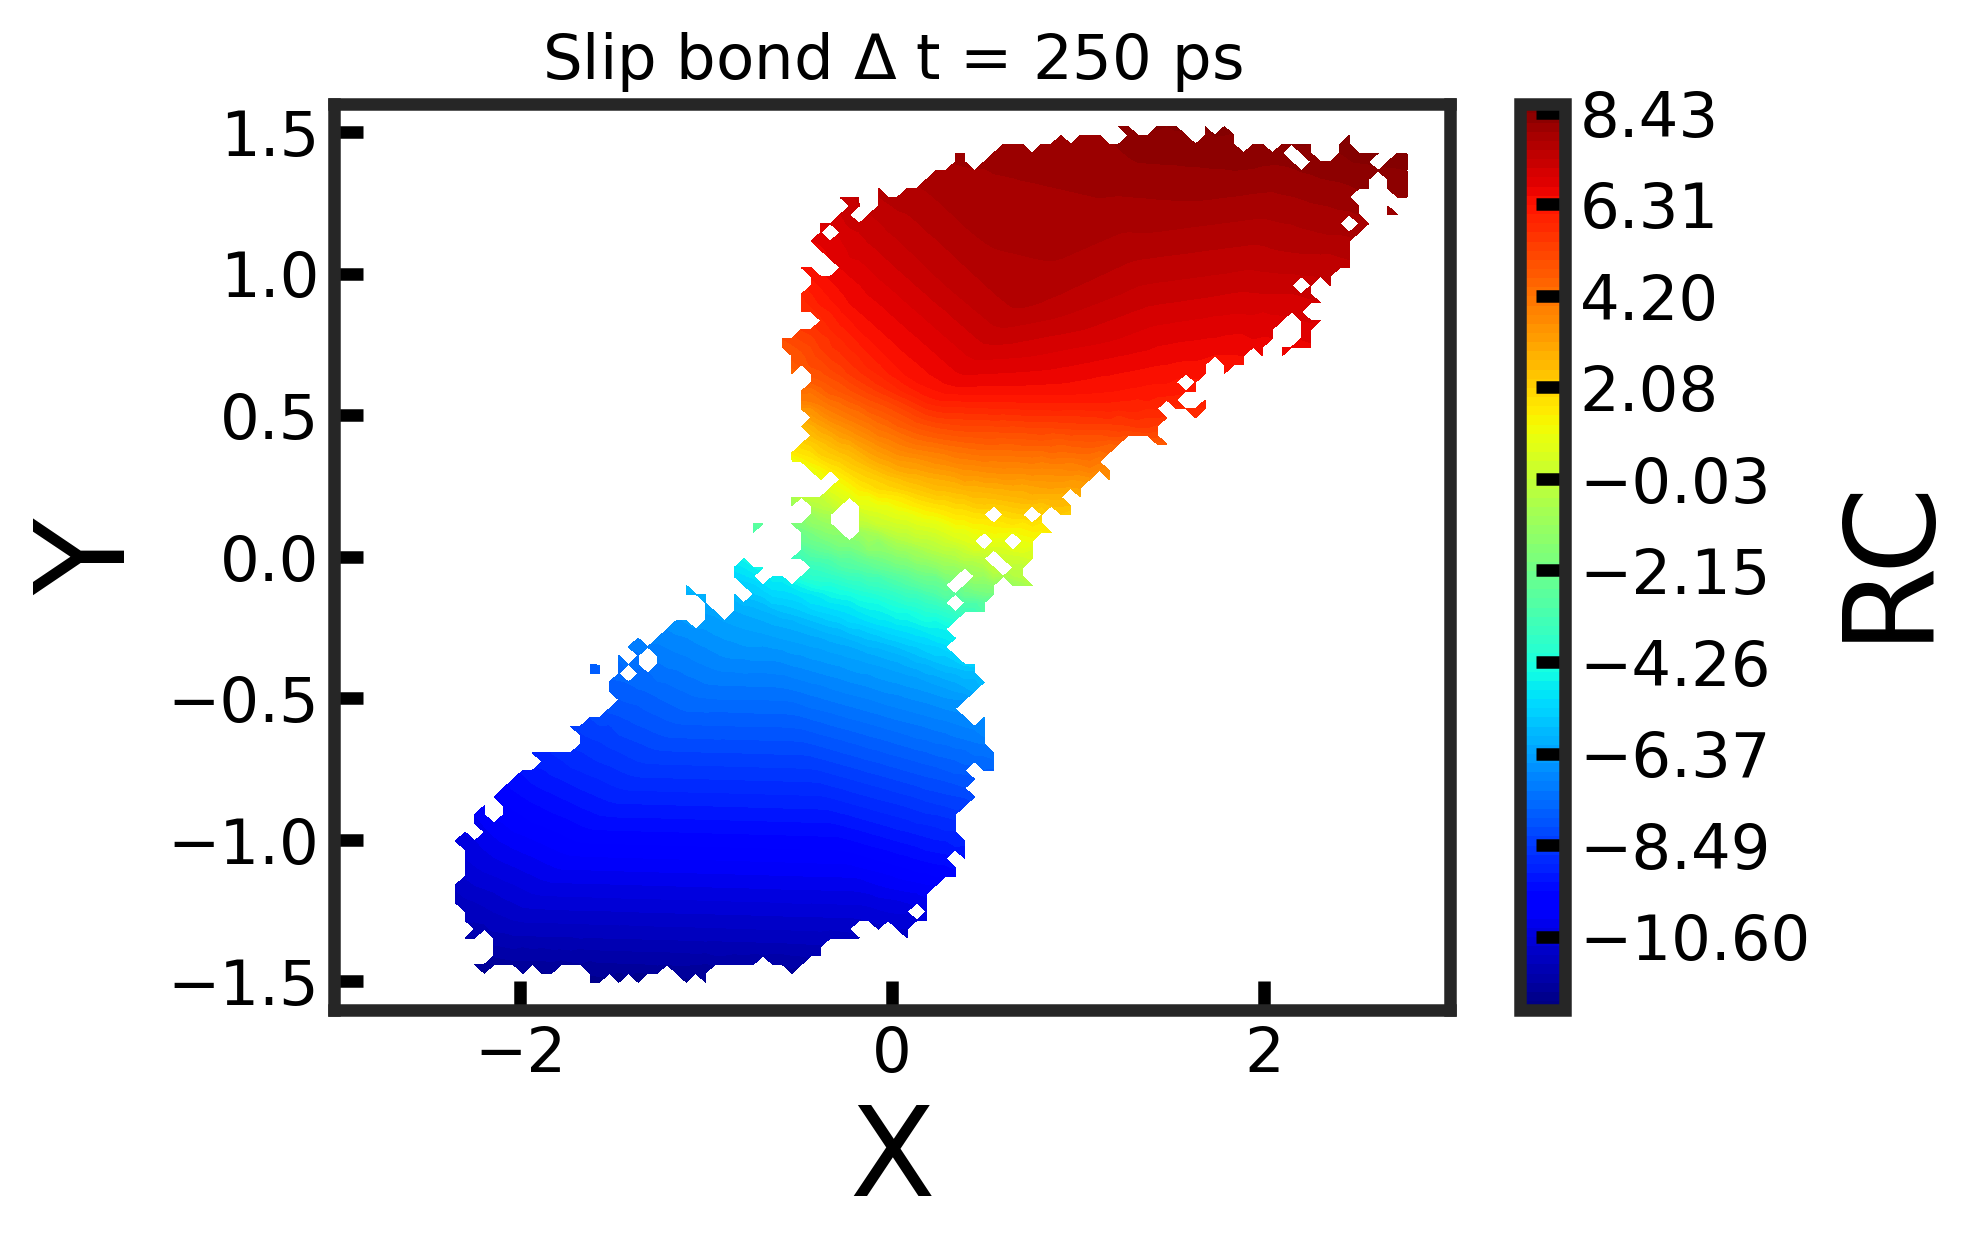

In [10]:
histdata,x,y = np.histogram2d(data[:,0],data[:,1],bins=100)
histMean,_,_ = np.histogram2d(data[:,0],data[:,1],bins=[x,y],weights=mean[:,0])
histRC = histMean/histdata
ax = plt.figure(dpi=300).add_subplot(111)

levels = np.linspace(mean[:,0].min(), mean[:,0].max(),100)
c = ax.contourf(x[:-1],y[:-1],histRC.T,cmap='jet',levels=levels)
cbar = plt.colorbar(c)
cbar.set_label("RC")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(-3,3)
ax.set_ylim(-1.6,1.6)
ax.set_title(r"Slip bond $\Delta$ t = 250 ps")

In [16]:
RC, FE_RC, _ = projectFEToRC(v, d,bins=100)

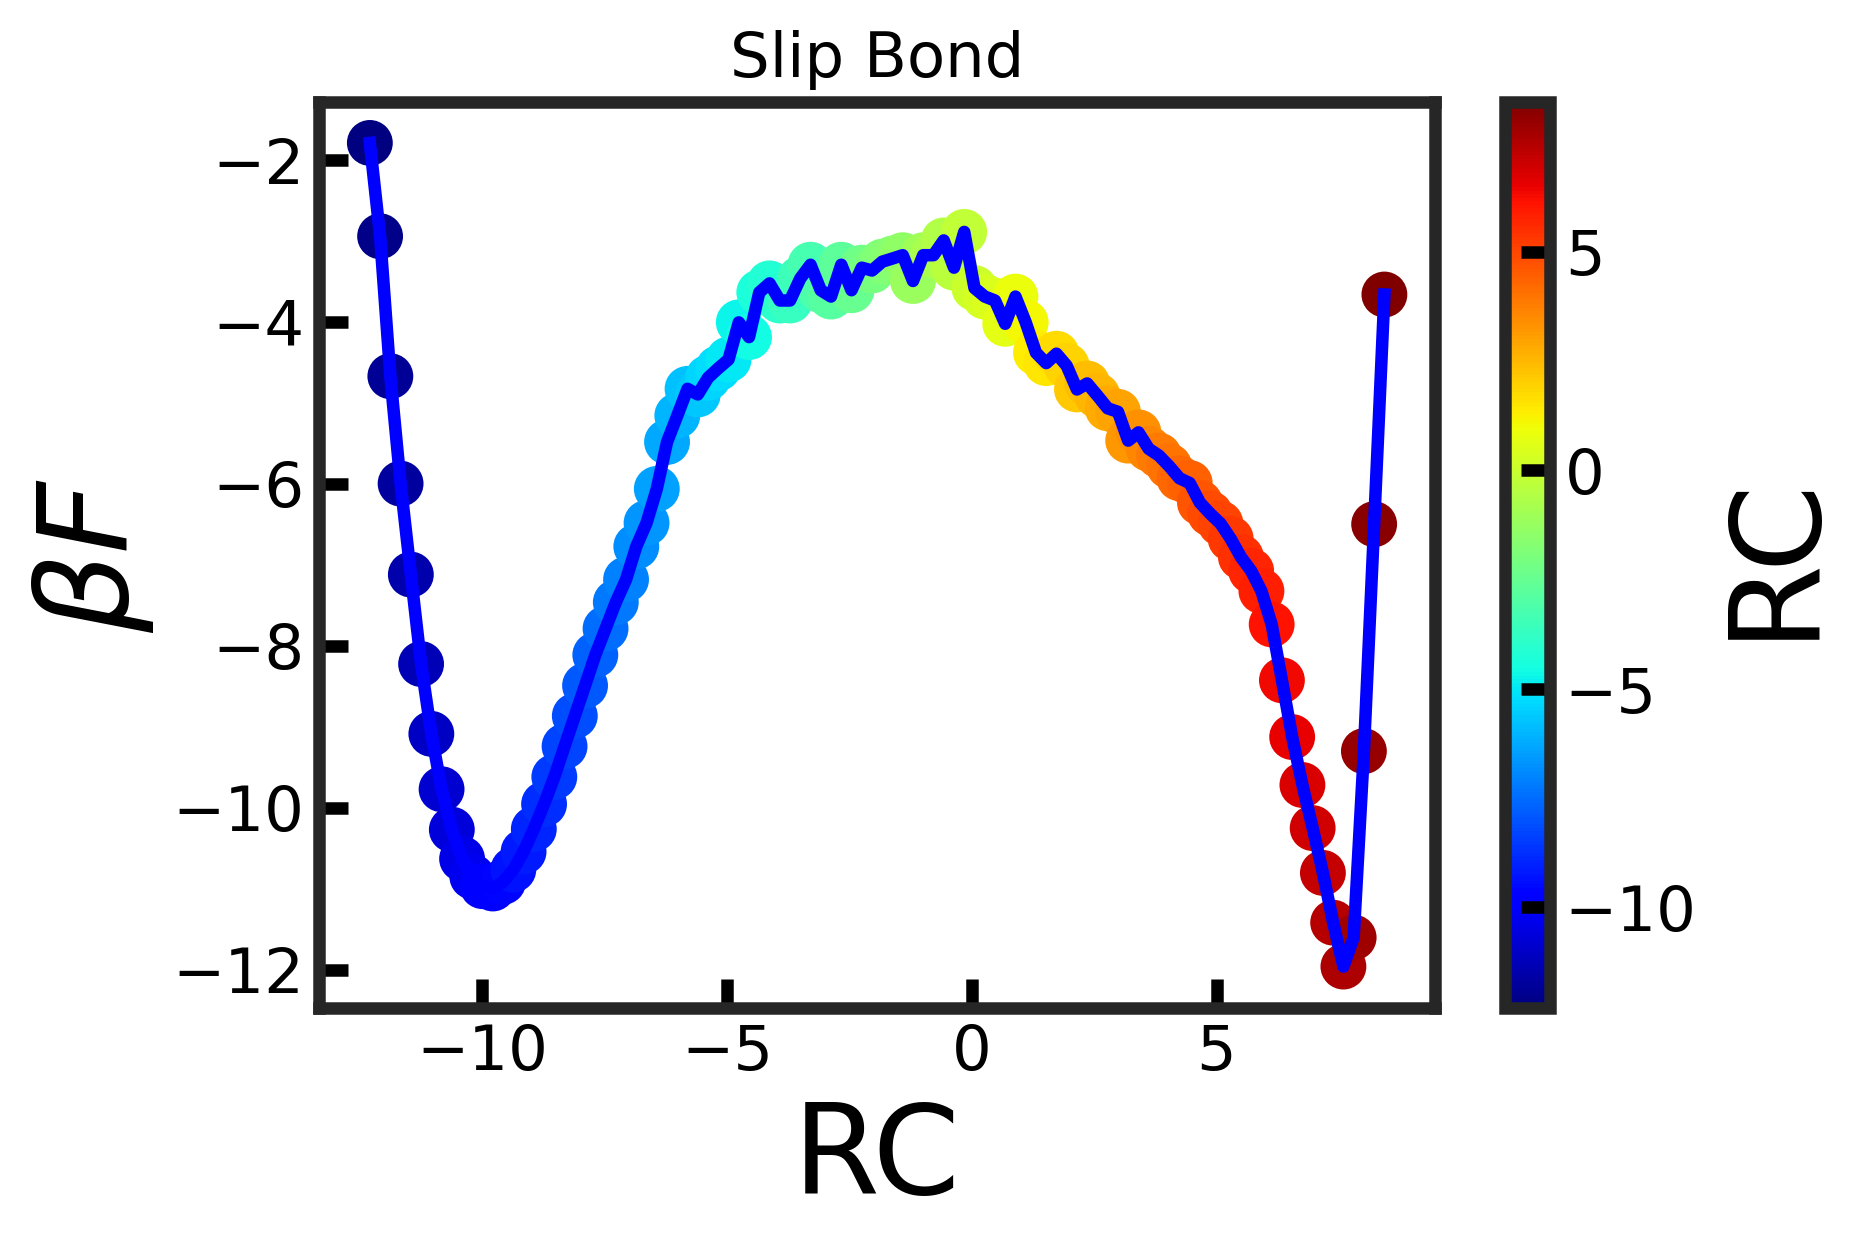

In [17]:
ax = plt.figure(dpi=300).add_subplot(111)
ax.plot(RC[:-1],FE_RC,c='b')
c = ax.scatter(RC[:-1], FE_RC ,c=RC[:-1],s=100,cmap='jet')
cbar = plt.colorbar(c)
ax.set_xlabel("RC")
ax.set_ylabel(r"$\beta F$")
ax.set_title("Slip Bond")
cbar.set_label(r"RC")